In [1]:
import glob
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

fs=glob.glob('/Users/mgrecu/GPM/2ADPR_tiles/*.nc')
fs=sorted(fs)
print(len(fs))

89


In [4]:
sfcPrecipL=[]
pTypeL=[]
zKuL=[]
bzdL=[]
bsfcL=[]
bcfL=[]
stormTopL=[]
for f in fs[:]:
    with nc.Dataset(f) as fh:
        #print(fh.variables.keys())
        stormTop=fh.variables['stormTop'][:]
        sfcPrecip=fh.variables['sfcPrecip'][:]
        sfcPrecipW=fh.variables['sfcPrecipW'][:]
        pType=fh.variables['pType'][:]
        bzd=fh.variables['bzd'][:]
        bsfc=fh.variables['bsfc'][:]
        bcf=fh.variables['bcf'][:]
        a=np.nonzero(pType[:,5,5]>=0)
        b=np.nonzero(bzd[a[0],5,5]<160)
        zKu=fh.variables['zKu'][:]
        zKuL.extend(zKu[a[0][b],5,5,:])
        stormTopL.extend(stormTop[a[0][b],5,5])
        bzdL.extend(bzd[a[0][b],5,5])
        bcfL.extend(bcf[a[0][b],5,5])
        bsfcL.extend(bsfc[a[0][b],5,5])
        sfcPrecipL.extend(sfcPrecipW[a[0][b],5,5])
        pTypeL.extend(pType[a[0][b],5,5])
    #break

In [3]:
print(len(sfcPrecipL))

66497


In [54]:

alpha_st=[0.0000861,0.0001084,0.0004142,0.000282,0.000285]
alpha_cv=[0.0000861,0.0001109,0.0004109,0.0004109,0.0004172]
beta_st=0.792
beta_cv=0.7713
dr=0.125
a_st,b_st=0.02282,0.6727
a_cv,b_cv=0.0424,0.6434
def hb(zKum,alpha,beta,dr,srt_piaKu):
    q=0.2*np.log(10)
    zeta=q*beta*alpha*10**(0.1*zKum*beta)*dr
    zetamax=1.-10**(-srt_piaKu/10.*beta)
    #zetamax=1.-10**(-4.0/10.*beta)
    if zeta.cumsum()[-1]>zetamax:
        eps=0.9999*zetamax/zeta.cumsum()[-1]
        zeta=eps*zeta
    else:
        eps=1.0
    corrc=eps*zeta.cumsum()
    zc=zKum-10/beta*np.log10(1-corrc)
    return zc,eps

In [59]:
sfcPrecipL=np.array(sfcPrecipL)
a=np.nonzero(sfcPrecipL>8)
print(sfcPrecipL[a[0]].sum()/sfcPrecipL.sum())
pst1_L=[]
pst2_L=[]
pcv1_L=[]
pcv2_L=[]
for i,zKu1 in enumerate(zKuL):
    bzd1=bzdL[i]
    bcf1=bcfL[i]
    stormTop1=stormTopL[i]
    itop=176-int(stormTop1/125)-5
    #print(bsfc1,bzd1,)
    dn_st=-0.2
    dn_cv=-0.5
    if pTypeL[i]==1 and bcf1>bzd1+2 and itop<bzd1-2:
        alpha=alpha_st
        beta=beta_st
        a=a_st
        b=b_st
        node=[itop,bzd1-2,bzd1,bzd1+2,bcf1]
        alpha=np.interp(range(itop,bcf1),node,alpha_st)
        alpha*=10**(dn_st*(1-beta_st))
        zku_true,eps=hb(zKu1[itop:bcf1],alpha,beta_st,dr,4)
        sfcRainRate_hb=a_st*10**(dn_st*(1-b_st))*10**(0.1*zku_true[-1]*b_st)
        pst1_L.append(sfcRainRate_hb)
        pst2_L.append(sfcPrecipL[i])
    if pTypeL[i]==2 and bcf1>bzd1+2 and itop<bzd1-2:
        alpha=alpha_cv
        beta=beta_cv
        node=[itop,bzd1-1,bzd1,bzd1+2,bcf1]
        alpha=np.interp(range(itop,bcf1),node,alpha_cv)
        alpha*=10**(dn_cv*(1-beta_cv))
        zku_true,eps=hb(zKu1[itop:bcf1],alpha,beta_cv,dr,10)
        sfcRainRate_hb=a_cv*10**(dn_cv*(1-b_cv))*10**(0.1*zku_true[-1]*b_cv)
        #print('hb',sfcRainRate_hb,sfcPrecipL[i],zku_true[-1])
        pcv1_L.append(sfcRainRate_hb)
        pcv2_L.append(sfcPrecipL[i])
    #break
    

0.2958124


1.0
66497


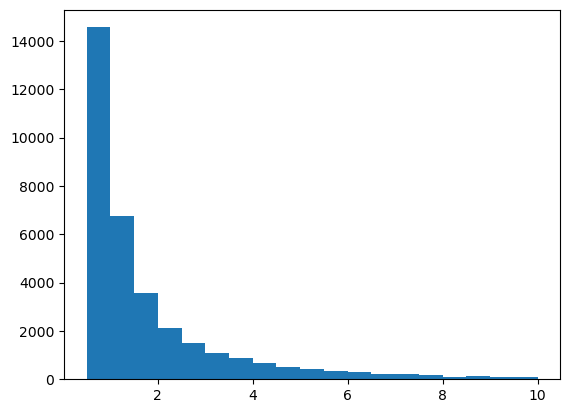

In [3]:
h1=plt.hist(sfcPrecipL,bins=np.arange(1,21)*0.5)
pTypeL=np.array(pTypeL)
a=np.where(pTypeL>0)
print(len(a[0])/len(pTypeL))
print(len(a[0]))